# Cascade of two-neuron modules
*Nhat Le, November 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import simulation_module as sim

%matplotlib inline

In [28]:
def ecdf(x):
    return np.sort(x), np.arange(len(x)) / len(x)

def save_safe(filename):
    '''Raise an error if file exists'''
    if not os.path.isfile(filename):
        plt.savefig(filename)
    else:
        raise IOError('File exists!')

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

## A Class for a two-neuron module

In [29]:
## Define an object class for simulation
class MultipleNeuronModule:
    def __init__(self, Wut, Wvt, Wuv, Wvu, theta, tau, dt, 
                 sigma_mu, sigma_sigma, threshold, K=0):
        '''Initialize a two-neuron module with parameters:
        Wut, Wvt, Wuv, Wvu: weights of the connections between u, v, and input (theta)
        theta: input
        tau: time constant
        dt: time step for simulation
        sigma_mu: indicates fluctuation in the mean between trials
        sigma_sigma: indicates the noise within each trial
        threshold: threshold for behavior, used to determine tp
        K: constant for updating
        '''
        self.Wut = Wut
        self.Wvt = Wvt
        self.Wuv = Wuv
        self.Wvu = Wvu
        self.theta = theta
        self.tau = tau
        self.dt = dt
        self.sigma_mu = sigma_mu
        self.sigma_sigma = sigma_sigma
        self.ext = 0
        self.threshold = threshold
        self.K = K
        self.Winh = np.matrix([[0, -Wuv], [-Wvu, 0]])
        self.Wexc = np.matrix([[0, 0], [0, 0]])
        self.state = np.matrix([0])
 
    def _initialize_state(self, u_init, v_init, ntrials, set_theta, theta):
        '''Initialize n states, each set to (u_init, v_init)
        ****Parameters****
        u_init, v_init: initial state of u and v
        ntrials: number of trials to simulate
        set_theta: if True, reset the default theta
        theta: if set_theta is True, use this theta as the input to the module '''
        
        self.ext = np.random.normal(0, self.sigma_mu, ntrials)
        if set_theta:
            self.theta = theta
            
        self.state = np.matrix([[u_init] * ntrials, [v_init] * ntrials])
        
    def _find_dstate(self):
        '''Find the change in the state vector at each update
        Input: It, the current
        Output: vector of dx (including du, dv)'''
        x = self.state
        noise = np.random.normal(loc=0, scale=self.sigma_sigma, size=self.state.shape)
        #print(noise)
        return (-x + thresh_exp(self.Wut * self.theta + self.Winh * x + \
                                self.Wexc * x + self.ext + noise)) / self.tau

    def _find_u_dot_multi(self):
        '''Based on the current state, calculate du/dt'''
        noise = np.random.normal(loc=0, scale=self.sigma_sigma, size=len(self.ustate))
        return (-self.ustate + thresh_exp(self.Wut * self.theta - \
                                          self.Wuv * self.vstate + noise + self.ext)) / self.tau
    
    def _find_v_dot_multi(self):
        '''Based on the current state, calculate dv/dt'''
        noise = np.random.normal(loc=0, scale=self.sigma_sigma, size=len(self.ustate))
        return (-self.vstate + thresh_exp(self.Wut * self.theta - \
                                          self.Wuv * self.ustate + noise + self.ext)) / self.tau

    def _update_state(self):
        '''Based on the current state, update to the state in the next time step'''
        self.state += self._find_dstate() * self.dt
    
    def simulate_full_trial(self, u_init, v_init, ntrials, nsteps, set_theta=False, theta=0):
        '''Simulate a full trial
        **** Parameters ****
        u_init, v_init: floats, initial state
        ntrials: int, number of trials to simulate
        nsteps: int, number of steps in each trial
        set_theta: if True, reset the default theta
        theta: if set_theta is True, use this theta as the input to the module
        **** Output ****
        U, V: numpy arrays of dimension ntrials x nsteps,
        the states of u and v over the course of simulation'''
        self._initialize_state(u_init, v_init, ntrials, set_theta, theta)
        self.u_lst = []
        self.v_lst = []        
        
        for i in range(nsteps):
            curr_state = self.state.copy()
            ustate_copy = np.squeeze(np.asarray(curr_state[0]))
            vstate_copy = np.squeeze(np.asarray(curr_state[1]))
            self.u_lst.append(ustate_copy)
            self.v_lst.append(vstate_copy)
            self._update_state()
        
        self.u_lst = np.vstack(self.u_lst)
        self.v_lst = np.vstack(self.v_lst)
        return self.u_lst, self.v_lst
    
    def get_decision_v(self):
        '''Returns a numpy array of dimension ntrials x nsteps,
        the projection of the (u, v) state onto the recurrent axis
        '''
        return self.u_lst - self.v_lst
    
    def get_feedback(self, time_feedback):
        '''**** Parameters ****
        time_feedback: int, the time the feedback signal is given
        **** Output ****
        '''
        
        return self.K * (self.get_decision_v()[time_feedback] - self.threshold) 
    
    def find_tp(self):
        decision_v = self.get_decision_v()
        times_lst = []
        for k in range(self.u_lst.shape[1]):
            if np.max(decision_v[:, k]) > self.threshold:
                times_lst.append(np.nonzero(decision_v[:, k] > self.threshold)[0][0])
            else:
                times_lst.append(np.inf)
                
        return np.array(times_lst)

In [30]:
# A Class for chained modules
class ChainedTwoNeuronModules:
    def __init__(self, modulelst):
        '''Initialize with modulelst: a list of TwoNeuronModule objects'''
        self.modulelst = modulelst
        # TODO: Threshold, tau and dt constraints?
        
    def find_tp(self):
        total_tp = 0
        for module in self.modulelst:
            total_tp = total_tp + module.find_tp()
        return total_tp
    
    def simulate_full_trial(self, u_init, v_init, ntrials, nsteps, t_feedback):
        for id, module in enumerate(self.modulelst):
            # No update for first module
            if id == 0:
                module.simulate_full_trial(u_init, v_init, ntrials, nsteps)
            else:
                module.simulate_full_trial(u_init, v_init, ntrials, nsteps, True, theta_next)
            
            theta_next = module.theta + module.get_feedback(t_feedback)
            

In [ ]:
module1 = sim.TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.613, tau=100, dt=1, 
                         sigma_mu=0.1, sigma_sigma=0.5, threshold=0.65, K=0)
module2 = sim.TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.613, tau=100, dt=1, 
                         sigma_mu=0.1, sigma_sigma=0.5, threshold=0.65, K=0)

simple_chained = ChainedTwoNeuronModules([module1, module2])

In [16]:
module1 = sim.TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.613, tau=100, dt=0.5, 
                         sigma_mu=0.0, sigma_sigma=0.0, threshold=0.65, K=0)

module2 = sim.MultipleNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.613, tau=100, dt=0.5, 
                         sigma_mu=0.0, sigma_sigma=0.0, threshold=0.65, K=0)



In [17]:
u1, v1 = module1.simulate_full_trial(0.7, 0.2, 1, 300, True, 0.1)
u2, v2 = module2.simulate_full_trial(0.7, 0.2, 1, 300, True, 0.1)

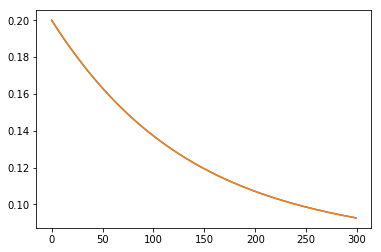

In [18]:
plt.plot(v1)
plt.plot(v2)

In [ ]:
uarr8, varr8 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.8)
uarr7, varr7 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.7)
uarr6, varr6 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.6)
uarr5, varr5 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.5)
uarr4, varr4 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.4)
uarr3, varr3 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.3)
uarr2, varr2 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.2)
uarr1, varr1 = module1.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.1)

In [19]:
uarr8, varr8 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.8)
uarr7, varr7 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.7)
uarr6, varr6 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.6)
uarr5, varr5 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.5)
uarr4, varr4 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.4)
uarr3, varr3 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.3)
uarr2, varr2 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.2)
uarr1, varr1 = module2.simulate_full_trial(0.7, 0.2, 2, 3000, True, 0.1)

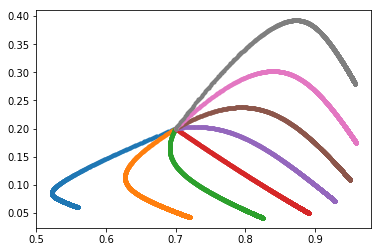

In [20]:
plt.plot(uarr1[:,0], varr1[:,0], '.')
plt.plot(uarr2[:,0], varr2[:,0], '.')
plt.plot(uarr3[:,0], varr3[:,0], '.')
plt.plot(uarr4[:,0], varr4[:,0], '.')
plt.plot(uarr5[:,0], varr5[:,0], '.')
plt.plot(uarr6[:,0], varr6[:,0], '.')
plt.plot(uarr7[:,0], varr7[:,0], '.')
plt.plot(uarr8[:,0], varr8[:,0], '.')

In [ ]:
simple_chained.simulate_full_trial(0.7, 0.2, 100, 1000, 50)
times = simple_chained.find_tp()
plt.hist(times)
print(np.mean(times))

In [ ]:
np.mean(times)

In [59]:
module = MultipleNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.613, tau=100, dt=1, 
                         sigma_mu=0.1, sigma_sigma=0.5, threshold=0.65, K=0)
a, b = module.simulate_full_trial(0.7, 0.2, 100, 1000)
times = module.find_tp()

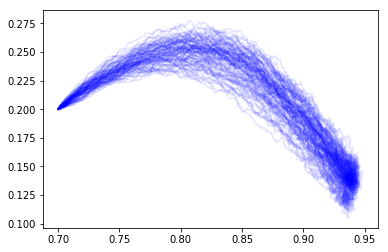

In [60]:
plt.plot(a,b,'b', alpha=0.1);

200.0


(array([  5.,   5.,  14.,  23.,  14.,  21.,   9.,   5.,   2.,   2.]),
 array([ 155. ,  165.2,  175.4,  185.6,  195.8,  206. ,  216.2,  226.4,
         236.6,  246.8,  257. ]),
 <a list of 10 Patch objects>)

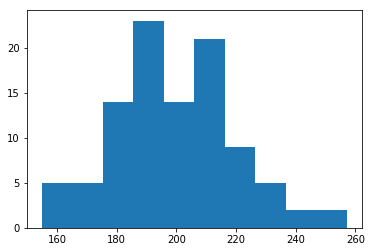

In [61]:
print(np.mean(times))
plt.hist(times)

In [62]:
module = sim.TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.613, tau=100, dt=1, 
                         sigma_mu=0.1, sigma_sigma=0.5, threshold=0.65, K=0)
a, b = module.simulate_full_trial(0.7, 0.2, 100, 1000)
times = module.find_tp()

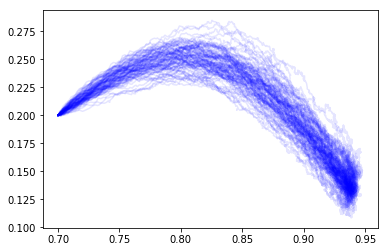

In [63]:
plt.plot(a,b,'b', alpha=0.1);

201.64


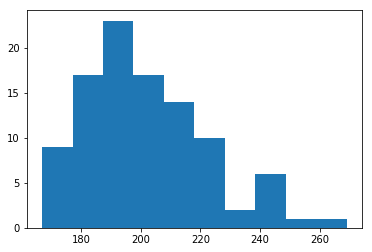

In [64]:
print(np.mean(times))
plt.hist(times);

## The no-noise condition

In [ ]:
thetas_lst = np.linspace(0.5, 0.7, 20)
module_no_noise = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=thetas_lst, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0, threshold=0.65, K=0)
ulst_no_noise, vlst_no_noise = module_no_noise.simulate_full_trial(0.7, 0.2, 20, 3000)
#times_no_noise = module_no_noise.find_tp()

In [ ]:
plt.plot(ulst_no_noise, vlst_no_noise, 'b');

In [ ]:
thetas_lst = np.linspace(0.5, 0.7, 20)
module_no_noise = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=thetas_lst, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0, threshold=0.65, K=0)
ulst_no_noise, vlst_no_noise = module_no_noise.simulate_full_trial(0.7, 0.2, 20, 3000)
times_no_noise = module_no_noise.find_tp()

A plot of the trajectories for 20 values of $\theta$ from 0.5 to 0.7 (no noise)

In [ ]:
plt.plot(ulst_no_noise, vlst_no_noise, 'b');
plt.scatter(ulst_no_noise[::100,:], vlst_no_noise[::100,:], color='r', zorder=4)
plt.title('Trajectory for single module, I = 0.6 to 0.8')

As expected, having two modules simply doubles the production time of a single module

In [ ]:
module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=np.linspace(0.5, 0.7, 20), tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0, threshold=0.65, K=0)
_ = module1.simulate_full_trial(0.7, 0.2, 20, 3000)
module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=np.linspace(0.5, 0.7, 20), tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0, threshold=0.65, K=0)
_ = module2.simulate_full_trial(0.7, 0.2, 20, 3000)

times1 = module1.find_tp()
times2 = module2.find_tp()

plt.plot(thetas_lst, times1, label='One module')
plt.plot(thetas_lst, times1 + times2, label='Two modules')
plt.ylim(0, 500)
plt.xlabel(r'$I_0$')
plt.ylabel(r'$T_p$')
plt.legend()
plt.title('One or two modules, no noise')

## Effect of $\sigma_\sigma$

We first simulate a single module. We adjust $\theta$ to make the mean time to threshold = 400

In [ ]:
# One module case to produce Tp = 400
module = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.752, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65)
ulst, vlst = module.simulate_full_trial(0.7, 0.2, 1000, 1000)
times_single = module.find_tp()

print('One module, mean = %f, variance = %f' % (np.mean(times_single), np.var(times_single)))

For two modules, we can again adjust $\theta$ to make sure the mean total time is 400

In [ ]:
# Two modules
module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.644, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65)
_ = module1.simulate_full_trial(0.7, 0.2, 1000, 3000)
module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.644, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65)
_ = module2.simulate_full_trial(0.7, 0.2, 1000, 3000)

times_two_modules = module1.find_tp() + module2.find_tp()

print('Two modules, mean = %f, variance = %f' % (np.mean(times_two_modules), np.var(times_two_modules)))

And we compare the distribution of times! The two modules has a lower variance (3.9 compared to 20.4). But why? I don't have a good intuition here.

In [ ]:
x1, y1 = ecdf(times_single)
x2, y2 = ecdf(times_two_modules)
plt.plot(x1, y1, label='Two modules')
plt.plot(x2, y2, label='Single module')
plt.xlabel('Tp')
plt.ylabel('Cumulative Frequency')
plt.legend()


## Update model

Now here's the part where we make use of the update. We assume the threshold information is known (kept at 0.65), and subtract the final state of the system from the threshold.

In [ ]:
# Two modules
varlst = []
meanlst = []
nK = 8
ntheta = 8
Klst = np.linspace(0, 3, nK)
thetalst = np.linspace(0.5, 0.7, ntheta)
meanlst = np.zeros((ntheta, nK))
varlst = np.zeros((ntheta, nK))

for idtheta, theta in enumerate(thetalst):
    print('theta = ', theta)
    for idK, K in enumerate(Klst):
        # Modules and chain
        print('    K = ', K)
        module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        chain = ChainedTwoNeuronModules([module1, module2])
        chain.simulate_full_trial(0.7, 0.2, 1000, 3000, 199)
        times_lst_sigma = chain.find_tp()

        meanlst[idtheta, idK] = np.mean(times_lst_sigma)
        varlst[idtheta, idK] = np.std(times_lst_sigma)

In [ ]:
plt.imshow(np.flipud(meanlst - 400), cmap='RdBu_r', aspect='auto', \
           extent=[0, 3, 0.5, 0.7], vmin=-100, vmax=100)
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias in Tp, $\sigma=0.3$')
#save_safe('bias_two_modules_sigma_0_3.pdf')

In [ ]:
plt.imshow(np.flipud(varlst), cmap='hot', aspect='auto', extent=[0, 3, 0.5, 0.6])
plt.colorbar()
plt.grid(False)
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.3$')
#save_safe('variance_two_modules_sigma_0_3.pdf')

In [ ]:
plt.imshow((np.log(np.flipud((meanlst - 400)**2 +  varlst))), cmap='hot', aspect='auto', extent=[0, 3, 0.5, 0.6])
plt.colorbar()
plt.grid(False)
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.3$')
#save_safe('bias_variance_two_modules_sigma_0_3.pdf')

An optimal value of $K = 1.5$ is found to minimize the variance in $T_p$. There seems to be a bias in the mean $T_p$ as well. The point of minimum variance also happens to have zero bias. Is this a coincidence?

## Effect of $\sigma_\sigma$

In the previous section we worked with a single value $\sigma_\sigma=0.3$. Here we would like to get a sense of how the optimal value of $K$ changes as a function of $\sigma_\sigma$.

This is the theta that will give an expected time of 400 for values of $\sigma_\sigma$ = 0, 0.1, 0.2, ..., 0.5

In [ ]:
theta_lst = np.array([[0    , 0.1  , 0.2  , 0.3  , 0.4  , 0.5  ],
                      [0.659, 0.658, 0.653, 0.644, 0.632, 0.613]])

In [ ]:
Klst = np.linspace(0, 3, 10)
varlst = np.zeros((6, 10))
meanlst = np.zeros((6, 10))

for i in range(theta_lst.shape[1]):
    sigma_sigma = theta_lst[0, i]
    theta = theta_lst[1, i]
    for j, K in enumerate(Klst):
        print('Working, i = ', i, 'K = ', K)
        # Module 1
        module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta2, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        chain = ChainedTwoNeuronModules([module1, module2])
        chain.simulate_full_trial(0.7, 0.2, 1000, 3000, 199)
        times_lst_sigma = chain.find_tp()
        
        varlst[i][j] = np.std(times_lst_sigma)
        meanlst[i][j] = np.mean(times_lst_sigma)

Interestingly, the bias is relatively constant while the minimum point of the variance occurs consistently at $K \approx 1.5$

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(1, 6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i-1].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i-1].plot(Klst, meanlst[i] - 400, color='g', label='Bias')
    ax[i-1].set_ylim((-10, 30))
    ax[i-1].set_xlabel(r'$K$')
    ax[i-1].set_title(r'$\sigma=$' + str(theta_lst[0, i-1]))
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[4].legend();
#save_safe('bias_variance_sigma_sigma.pdf')


## Effect of $\sigma_\mu$

We now turn to the effect of $\sigma_\mu$ and try to find values of $K$ that help the system correct its $T_p$. My previous result has shown that the bias of $T_p$ can be kept close to 0 at certain values of $\theta$, while the variance can be controlled by $K$. Thus, we can reuse the $\theta$ table obtained previously to set the right $I$ for the system to achieve time = 400.

In [ ]:
# Two modules
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
mu_ext = np.random.normal(0, 0.3, ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}

module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.644, tau=100, dt=1, 
                         sigma_mu=0.3, sigma_sigma=0, threshold=0.65)
module1.simulate_full_trial(0.7, 0.2, 1000, 3000)

module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0.3, sigma_sigma=0, threshold=0.65)
module2.simulate_full_trial(0.7, 0.2, 1000, 3000)
times_lst_sigma = module1.find_tp() + module2.find_tp()

print(np.mean(times_lst_sigma))

Again we see the familiar shape of the $\sigma_\mu$ trials with a more 'ordered' time steps. At large values of $\sigma_\mu$, deviations can be detrimental as the system never crosses threshold.

In [ ]:
plt.plot(module1.u_lst, module1.v_lst, 'b', alpha=0.03);
plt.scatter(module1.u_lst[::100,:], module1.v_lst[::100,:], color='r');

Now we try to introduce updating with $K$ and see what happens

In [ ]:
# Two modules
varlst = []
meanlst = []
Klst = np.linspace(0, 4, 20)
meanlst = np.zeros((10, 20))
varlst = np.zeros((10, 20))

for idtheta, theta in enumerate(np.linspace(0.5, 0.7, 10)):
    print('theta = ', theta)
    for idK, K in enumerate(Klst):
        param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}
        # Module 1
        print('    K = ', K)
        module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta2, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        chain = ChainedTwoNeuronModules([module1, module2])
        chain.simulate_full_trial(0.7, 0.2, 1000, 3000, 199)
        times_lst_sigma = chain.find_tp()
        
        meanlst[idtheta, idK] = np.mean(times_lst_sigma[times_lst_sigma < np.inf])
        varlst[idtheta, idK] = np.std(times_lst_sigma[times_lst_sigma < np.inf])

In [ ]:
plt.imshow(np.flipud(meanlst - 400), cmap='RdBu_r', aspect='auto', \
           vmin = -100, vmax=100, extent=[0, 4, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias in Tp, $\sigma=0.1$')
#save_safe('bias_two_modules_sigma_mu_0_1.pdf')

In [ ]:
plt.imshow(np.flipud(varlst), cmap='hot', aspect='auto', \
           extent=[0, 4, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.1$')
#save_safe('variance_two_modules_sigma_mu_0_1.pdf')

In [ ]:
plt.imshow(np.log(np.flipud(varlst + (meanlst - 400)**2)), cmap='hot', aspect='auto', \
           extent=[0, 3, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias + variance in Tp, $\sigma=0.1$')
#save_safe('bias_variance_two_modules_sigma_mu_0_1.pdf')

Some preliminary conclusions: (1) The value of $\theta$ computed in the table seems to give the lowest bias in  mean $T_p$ (2) Changing $\theta$ around this value shifts the Mean $T_p$ curve left or right and does not change the minimum point of the variance. Thus we can make the zero bias coincide with the minimum point in variance

## Choosing $t_s$ from a prior

Now we pick $t_s$ from a prior, the uniform distribution over $[300, 500]$. We will simulate two modules with $\sigma_\sigma=0.1$ and calculate the objective $\sum_{i=1}^N (t_p-t_s)^2$

In [ ]:
nK = 10
ntheta = 10

mselst = np.zeros((nK, ntheta))
Klst = np.linspace(1, 3, nK)
thetalst = np.linspace(0.5, 0.7, ntheta)
nts = 15
ntrials = 1000
ts = np.linspace(300, 500, nts)
tsnew = np.tile(ts, (1000, 1)).T
tsrep = np.tile(ts, (ntrials, 1)).T


for theta in [0.63]: #enumerate(thetalst):
    for K in [2.1]: #enumerate(Klst):
        print('K = ', K)
        # First build the chained modules
        module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                                 sigma_mu=0, sigma_sigma=0.1, threshold=0.65, K=K)
        module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.1, threshold=0.65, K=K)
        chain = ChainedTwoNeuronModules([module1, module2])

        # Simulate picking from the prior. We'll do 1000 trials
        tstp_lst = np.zeros((nts, ntrials))
        for i in range(nts):
            # Pick a ts
            print(i)
            chain.simulate_full_trial(0.7, 0.2, ntrials, nsteps=1000, t_feedback=int(ts[i] / 2))
            times_lst_sigma = chain.find_tp()
            tstp_lst[i, :] = times_lst_sigma

        mse = np.sum((tstp_lst - tsnew)**2)
        mselst[idtheta, idK] = mse

In [ ]:
mse

In [ ]:
plt.imshow(np.flipud(np.log(mselst)), cmap='hot', extent=[1, 3, 0.5, 0.7], aspect='auto')

In [ ]:
plt.plot(Klst, mselst)

In [ ]:
plt.plot(np.mean(tstp_lst, axis=1), np.std(tstp_lst, axis=1), '.')
plt.xlim([0, 600])
plt.ylim([0, 10])

In [ ]:
tsnew = np.tile(ts, (1000, 1)).T
plt.scatter(tsnew, tstp_lst, alpha=0.2)
plt.plot(ts, ts)
plt.plot(ts, np.mean(tstp_lst, axis=1))

Thought: need to change both $I_0$ and $K$ in order to minimize mean squared error.

In [ ]:
mse

In [ ]:
np.sum((tstp_lst - tsnew)**2)

In [ ]:
def simulate_multiple_modules(ntrials, nsteps, total_duration, Kval, nmodules, sigma_mu, sigma_sigma):
    '''Simulate multiple modules in a cascade.
    ntrials: number of trials
    nsteps: number of time steps per trial
    total_duration: total time steps for N modules
    Kval: constant K for updating input
    nmodules: number of modules'''
    param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': sigma_sigma}
    subgoal = int(total_duration / nmodules)
    
    # Initial input to module 1
    ext_module_init = np.random.normal(loc=0, scale=sigma_mu, size=ntrials)

    for i in range(nmodules):
        print('Simulating module', i)
        if i == 0:
            ext_module, final_pos, total_times = simulate_module(ntrials, nsteps, subgoal, ext_module_init, 
                                                      param_dict_module, 
                                          K=Kval, ext_updating=False)
        else:
            ext_module, final_pos, times_lst = simulate_module(ntrials, nsteps, subgoal, ext_module, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos, ext_updating=True)
            total_times += times_lst
    return total_times

In [ ]:
palette = sns.hls_palette(8, l=0.5, s=0.8)
#palette = sns.color_palette('hls', 10)
for i in range(1, 9):
    time_lst = simulate_multiple_modules(1000, 5000, 1500, 3, i, 0.5, 0.2)
    x, y = ecdf(time_lst)
    plt.plot(x, y, color=palette[i - 1], label=str(i))
plt.legend(title='N modules', ncol=2)
plt.xlabel('Time (steps)')
plt.ylabel('Cumulative Frequency')
#save_safe('cascade_performance.pdf')

In [ ]:
ntrials = 100
nsteps = 5000
goal = 500
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)

In [ ]:
times_lst1 + times_lst2 + times_lst3

In [ ]:
ntrials = 100
nsteps = 5000
goal = 150
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)
ext_module4, final_pos4, times_lst4 = simulate_module(ntrials, nsteps, goal, ext_module3, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos3, ext_updating=True)
ext_module5, final_pos5, times_lst5 = simulate_module(ntrials, nsteps, goal, ext_module4, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos4, ext_updating=True)
ext_module6, final_pos6, times_lst6 = simulate_module(ntrials, nsteps, goal, ext_module5, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos5, ext_updating=True)
ext_module7, final_pos7, times_lst7 = simulate_module(ntrials, nsteps, goal, ext_module6, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos6, ext_updating=True)
ext_module8, final_pos8, times_lst8 = simulate_module(ntrials, nsteps, goal, ext_module7, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos7, ext_updating=True)
ext_module9, final_pos9, times_lst9 = simulate_module(ntrials, nsteps, goal, ext_module8, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos8, ext_updating=True)
ext_module10, final_pos10, times_lst10 = simulate_module(ntrials, nsteps, goal, ext_module9, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos9, ext_updating=True)

In [ ]:
plt.hist(times_lst1[times_lst1 < 1000], normed=True, range=(0, 1000))
plt.hist(times_lst2[times_lst2 < 1000], normed=True)
plt.hist(times_lst3[times_lst3 < 1000], normed=True)
plt.hist(times_lst_single[times_lst_single < 1000], normed=True)
#plt.xlim(0, 1000)

In [ ]:
# Module 1!
ntrials = 100
nsteps = 0
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module1 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.1}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_module1, 300)
final_pos1 = (ulst_noise1 - vlst_noise1)[-1, :]

In [ ]:
decision_v = ulst_noise1 - vlst_noise1
plt.plot(decision_v);

In [ ]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise1[100,:], vlst_noise1[100,:], color='r', marker='.');
plt.scatter(ulst_noise1[200,:], vlst_noise1[200,:], color='r', marker='.');
plt.scatter(ulst_noise1[300,:], vlst_noise1[300,:], color='r', marker='.');
plt.plot(k , 1 - k, '--')

In [ ]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]

In [ ]:
plt.figure(figsize=(5, 4))
plt.scatter(ext_module1, ext_module1, label=r'$I_1$ bias')
plt.scatter(ext_module1, ext_module2, label=r'$I_2$ bias')
plt.scatter(ext_module1, ext_module3, label=r'$I_3$ bias')
plt.xlabel(r'$I_1$ bias')
plt.ylabel(r'$I_2, I_3$ bias')
plt.legend()
save_safe('bias_three_modules_sigma_mu_K-4.pdf')

In [ ]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise1[100,:], vlst_noise1[100,:], color='r', marker='.');
plt.scatter(ulst_noise1[200,:], vlst_noise1[200,:], color='r', marker='.');
plt.scatter(ulst_noise1[300,:], vlst_noise1[300,:], color='r', marker='.');
plt.plot(k , 1 - k + 0.2, '--')

In [ ]:
plt.scatter(ext_module1, ext_module2)
plt.plot(ext_module1, ext_module1)

In [ ]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]


In [ ]:
plt.plot(ulst_noise2, vlst_noise2, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise2[100,:], vlst_noise2[100,:], color='r', marker='.');
plt.scatter(ulst_noise2[200,:], vlst_noise2[200,:], color='r', marker='.');
plt.scatter(ulst_noise2[300,:], vlst_noise2[300,:], color='r', marker='.');

plt.plot(k , 1 - k + 0.2, '--')

In [ ]:
plt.figure(figsize=(4, 4))
plt.hist(final_pos1 - np.mean(final_pos1), normed=True, alpha=1, label='Module 1', zorder=5)
plt.hist(final_pos2 - np.mean(final_pos2), normed=True, alpha=0.8, label='Module 2', zorder=4)
plt.hist(final_pos3 - np.mean(final_pos3), normed=True, alpha=0.8, label='Module 3', zorder=3)
plt.xlabel('Bias along recurrent axis')
plt.ylabel('Normalized Frequency')
plt.legend(loc='upper left')
save_safe('bias_three_modules.pdf')

In [ ]:
plt.scatter(ext_module1, ext_module2, marker='.')
plt.scatter(ext_module1, ext_module3, marker='.')
plt.scatter(ext_module1, ext_module1, marker='.')
plt.xlabel(r'$I_1$')

In [ ]:
# Module 3!
ref3 = np.mean(final_pos2)
k3 = 2
ext_module3 = (ext_module2 + k3 * (final_pos2 - ref3))

param_dict_module3 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module3, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise3, vlst_noise3 = simulate_u_v_exp_multi(state_dict, param_dict_module3, 400)
final_pos3 = (ulst_noise3 - vlst_noise3)[-1, :]
action_times = get_times_lst(state_dict, param_dict_module3, 1000, thresh)



In [ ]:
# Module 4 (readout)
ref4 = 1
k4 = 5
thresh = 0.8
ext_module4 = (ext_module3 - k4 * (final_pos3 - ref4))
param_dict_module4 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module4, 'sigma': 0}


action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)
x, y = ecdf(action_times)
plt.plot(x, y)

In [ ]:
# Compare to a single module
action_times2 = get_times_lst(state_dict, param_dict_module1, 1000, thresh)
action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)

x1, y1 = ecdf(action_times)
x2, y2 = ecdf(action_times2)
plt.plot(x1, y1)
plt.plot(x2, y2)

## Effect of $\sigma_\sigma$

In [ ]:
# Module 1!
ntrials = 100
nsteps = 400
#ext_module1 = np.random.normal(loc=0, scale=0.1, size=ntrials)
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.6}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)
ulst_no_noise, vlst_no_noise = simulate_u_v_exp_multi(state_dict, param_dict_no_noise, nsteps)

decision_v = ulst_noise1 - vlst_noise1
final_pos = decision_v[-1]
ref_decision = np.mean(final_pos)

ext_lst = ref_decision - final_pos

In [ ]:
# Module 2!
param_dict_noise['ext'] = ext_lst * 10
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)

decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = decision_v2[-1]
ref_decision2 = np.mean(final_pos2)

ext_lst2 = ref_decision2 - final_pos2


In [ ]:
plt.plot(ulst_noise1, vlst_noise1, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise1[-1], vlst_noise1[-1], color='r', marker='.')

In [ ]:
plt.plot(ulst_noise2, vlst_noise2, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise2[-1], vlst_noise2[-1], color='r', marker='.')